# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [1]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2023-01-28 06:28:16--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7882203 (7.5M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.52M  37.7MB/s    in 0.2s    

2023-01-28 06:28:17 (37.7 MB/s) - ‘ita-eng.zip’ saved [7882203/7882203]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [2]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2023-01-28 06:28:21--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2023-01-28 06:28:22--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc001adc736ec94777085aeb42e6.dl.dropboxusercontent.com/cd/0/inline/B1YDDX6PXN0TmDRTTzD7e6Bz6ZnbwYM0fokYx5fookCJ9J6PZ6vJFh-TmPRVmCsKbel-kimE5dxbn1AV3tlJ1AC4Wu9MSTS2Hyc4zQztzE8it1CVUxOIwn2eoV5v67sQRMJ058rWz5MSXPKdlhJoxNW4J0Dhz_80rmbjCnL6VwIinA/file# [following]
--2023-01-28 06:28:23--  https://uc001adc736ec94777085aeb42e6.dl.dropboxusercontent.com/cd/0/inline/B1YDDX6PXN0TmDRTTzD7e6Bz6ZnbwYM0fokYx5fookCJ9J6PZ6vJFh-TmPRVmCs

<font color='blue'>**Preprocess data**</font>

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [5]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(358373, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [6]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [7]:
data['english_input']='<start> ' +data['english'].astype(str)

data['english_output']=data['english'].astype(str) + ' <end>'

data = data.drop(['english'], axis=1)

In [8]:
data.head(5)

,italian,english_input,english_output
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [9]:
from sklearn.model_selection import train_test_split
train_1, test = train_test_split(data, test_size=0.2)
train, validation = train_test_split(train_1, test_size=0.2)

In [10]:
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_input']= str(train.iloc[0]['english_input'])+' <end>'
train.iloc[0]['english_output']= str(train.iloc[0]['english_output'])+' <end>'

validation.iloc[0]['english_input']= str(validation.iloc[0]['english_input'])
validation.iloc[0]['english_output']= str(validation.iloc[0]['english_output'])

test.iloc[0]['english_input']= str(test.iloc[0]['english_input'])
test.iloc[0]['english_output']= str(test.iloc[0]['english_output'])

In [11]:
tknizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_ita.fit_on_texts(train['italian'].values)

italian_train=tknizer_ita.texts_to_sequences(train['italian'].values)
italian_validation=tknizer_ita.texts_to_sequences(validation['italian'].values)

tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_input'].values)

english_train=tknizer_eng.texts_to_sequences(train['english_input'].values)
english_validation=tknizer_eng.texts_to_sequences(validation['english_input'].values)

english_train_target=tknizer_eng.texts_to_sequences(train['english_output'].values)
english_validation_target=tknizer_eng.texts_to_sequences(validation['english_output'].values)

In [12]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english_input'].str.split().apply(len)

In [13]:
print('Max Italian Length')
print('_'*50)
for i in range(0,101,10):
    print('The {} Percentile is {}'.format(i,np.percentile(ita_lengths, i)))
print('*'*50)
for i in range(90,101):
    print('The {} Percentile is {}'.format(i,np.percentile(ita_lengths, i)))
print('*'*50)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print('The {} Percentile is {}'.format(i,np.percentile(ita_lengths, i)))

Max Italian Length
__________________________________________________
The 0 Percentile is 1.0
The 10 Percentile is 3.0
The 20 Percentile is 4.0
The 30 Percentile is 4.0
The 40 Percentile is 5.0
The 50 Percentile is 5.0
The 60 Percentile is 6.0
The 70 Percentile is 6.0
The 80 Percentile is 7.0
The 90 Percentile is 8.0
The 100 Percentile is 92.0
**************************************************
The 90 Percentile is 8.0
The 91 Percentile is 8.0
The 92 Percentile is 8.0
The 93 Percentile is 9.0
The 94 Percentile is 9.0
The 95 Percentile is 9.0
The 96 Percentile is 9.0
The 97 Percentile is 10.0
The 98 Percentile is 11.0
The 99 Percentile is 12.0
The 100 Percentile is 92.0
**************************************************
The 99.1 Percentile is 12.0
The 99.2 Percentile is 12.0
The 99.3 Percentile is 13.0
The 99.4 Percentile is 13.0
The 99.5 Percentile is 13.0
The 99.6 Percentile is 14.0
The 99.7 Percentile is 15.0
The 99.8 Percentile is 16.0
The 99.9 Percentile is 22.0
The 100 Percentile i

In [14]:
print('Max English Length')
print('_'*50)
for i in range(0,101,10):
    print('The {} Percentile is {}'.format(i,np.percentile(eng_lengths, i)))
print('*'*50)
for i in range(90,101):
    print('The {} Percentile is {}'.format(i,np.percentile(eng_lengths, i)))
print('*'*50)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print('The {} Percentile is {}'.format(i,np.percentile(eng_lengths, i)))

Max English Length
__________________________________________________
The 0 Percentile is 2.0
The 10 Percentile is 5.0
The 20 Percentile is 5.0
The 30 Percentile is 6.0
The 40 Percentile is 6.0
The 50 Percentile is 7.0
The 60 Percentile is 7.0
The 70 Percentile is 8.0
The 80 Percentile is 8.0
The 90 Percentile is 9.0
The 100 Percentile is 102.0
**************************************************
The 90 Percentile is 9.0
The 91 Percentile is 10.0
The 92 Percentile is 10.0
The 93 Percentile is 10.0
The 94 Percentile is 10.0
The 95 Percentile is 10.0
The 96 Percentile is 11.0
The 97 Percentile is 11.0
The 98 Percentile is 12.0
The 99 Percentile is 13.0
The 100 Percentile is 102.0
**************************************************
The 99.1 Percentile is 13.0
The 99.2 Percentile is 14.0
The 99.3 Percentile is 14.0
The 99.4 Percentile is 14.0
The 99.5 Percentile is 15.0
The 99.6 Percentile is 15.0
The 99.7 Percentile is 16.0
The 99.8 Percentile is 17.0
The 99.9 Percentile is 26.0
The 100 Perc

In [15]:
italian_pad_length=22
english_pad_length=26
print(italian_pad_length)
print(english_pad_length)

22
26


In [16]:
padded_english_train=tf.keras.utils.pad_sequences(english_train, maxlen=english_pad_length,padding='post' )
padded_italian_train=tf.keras.utils.pad_sequences(italian_train, maxlen=italian_pad_length,padding='post' )
padded_english_target_train=tf.keras.utils.pad_sequences(english_train_target, maxlen=english_pad_length,padding='post' )

padded_english_validation=tf.keras.utils.pad_sequences(english_validation, maxlen=english_pad_length,padding='post' )
padded_italian_validation=tf.keras.utils.pad_sequences(italian_validation, maxlen=italian_pad_length,padding='post' )
padded_english_target_validation=tf.keras.utils.pad_sequences(english_validation_target, maxlen=english_pad_length,padding='post' )

In [17]:
vocab_size_eng=max(tknizer_eng.word_index.values())
print(vocab_size_eng)
vocab_size_ita=max(tknizer_ita.word_index.values())
print(vocab_size_ita)

12596
25244


In [18]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 9642)

In [19]:
from tqdm import tqdm
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

400000it [00:11, 35454.38it/s]


In [20]:
embedding_matrix.shape

(12597, 100)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.inp_vocab_size=inp_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length

    def build(self,input_shape):
        self.embedding_layer=Embedding(self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,mask_zero=True )
        self.lstm_layer=LSTM(self.lstm_size, return_sequences=True, return_state=True)
        
    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_1=self.embedding_layer(input_sequence)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm_layer(input_1,initial_state=states )

        return encoder_outputs,encoder_state_h,encoder_state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      initial_hidden_state=tf.zeros((batch_size,self.lstm_size))
      initial_cell_state=tf.zeros((batch_size,self.lstm_size))

      return initial_hidden_state,initial_cell_state

<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        super().__init__()
        self.out_vocab_size=out_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
        
    def build(self, input_shape):
        self.embedding_layer=Embedding(self.out_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,mask_zero=True,weights=[embedding_matrix], trainable=False)
        self.lstm_layer=LSTM(self.lstm_size,return_sequences=True, return_state=True,)


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        input_2=self.embedding_layer(input_sequence)
        decoder_output,decoder_final_state_h,decoder_final_state_c=self.lstm_layer(input_2, initial_state=initial_states)

        return decoder_output,decoder_final_state_h,decoder_final_state_c


<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,inp_vocab_size, embedding_size, lstm_size,decoder_input_length, encoder_input_length,out_vocab_size, batch_size):
        super().__init__()
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'

        self.encoder=Encoder(inp_vocab_size, embedding_size, lstm_size,encoder_input_length)
        self.decoder=Decoder(out_vocab_size, embedding_size, lstm_size, decoder_input_length)
        self.soft_max=Dense(out_vocab_size, 'softmax')
        self.batch_size=batch_size
    
    def call(self,data):#,*params
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        states=self.encoder.initialize_states(self.batch_size)
        
        input_sequence,target_sequence =data[0], data[1]
        
        encoder_output,encoder_final_state_h,encoder_final_state_c=self.encoder(input_sequence,states)
        decoder_output,decoder_final_state_h,decoder_final_state_c =self.decoder(target_sequence, initial_states=[encoder_final_state_h,encoder_final_state_c])
        
        encoder_final_state_h,encoder_final_state_c=decoder_final_state_h,decoder_final_state_c
        dense_output=self.soft_max(decoder_output)

        return dense_output

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_input'].values
        self.decoder_outs = data['english_output'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_ita = max_len_ita
        self.max_len_eng = max_len_eng

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset=Dataset(train, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)
validation_dataset=Dataset(validation, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)
test_dataset=Dataset(test, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)

size=512

train_data_loader=Dataloder(train_dataset, batch_size=size)
validation_data_loader=Dataloder(validation_dataset, batch_size=size)
test_data_loader=Dataloder(test_dataset, batch_size=size)

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
lr_rate=tf.keras.callbacks.ReduceLROnPlateau(patience=4,min_delta=0.01)
stopping=tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=3)

callbacks=[tensorboard,checkpoint,lr_rate,stopping]
size=512
model=Encoder_decoder(inp_vocab_size=(vocab_size_ita+1), embedding_size=100, lstm_size=50, decoder_input_length=english_pad_length, encoder_input_length=italian_pad_length,out_vocab_size=(vocab_size_eng+1),batch_size=size)
input_data=[padded_italian_train,padded_english_train]
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy')
model.fit(train_data_loader,epochs=50, batch_size=size,validation_data=validation_data_loader  )

Epoch 1/50
447/447 [==============================] - 131s 293ms/step - loss: 6.1651 - val_loss: 5.4263
Epoch 2/50
447/447 [==============================] - 131s 292ms/step - loss: 5.4333 - val_loss: 5.4163
Epoch 3/50
447/447 [==============================] - 135s 302ms/step - loss: 5.3870 - val_loss: 5.3149
Epoch 4/50
447/447 [==============================] - 137s 306ms/step - loss: 5.2622 - val_loss: 5.1537
Epoch 5/50
447/447 [==============================] - 135s 301ms/step - loss: 4.9261 - val_loss: 4.6895
Epoch 6/50
447/447 [==============================] - 130s 292ms/step - loss: 4.4870 - val_loss: 4.2877
Epoch 7/50
447/447 [==============================] - 154s 344ms/step - loss: 4.1264 - val_loss: 3.9969
Epoch 8/50
447/447 [==============================] - 133s 298ms/step - loss: 3.8745 - val_loss: 3.7850
Epoch 9/50
447/447 [==============================] - 130s 292ms/step - loss: 3.6725 - val_loss: 3.6102
Epoch 10/50
447/447 [==============================] - 134s 300m

In [ ]:
def predict(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
           predicted_out,state_h,state_c=model.layers[1](dec_input,states)
           pass the predicted_out to the dense layer
           update the states=[state_h,state_c]
           And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
           Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    output_sentence=[]
    batch_size=1
    tokenized_sent=tknizer_ita.texts_to_sequences([input_sentence])
    #print(tokenized_sent)
    padded_sent=padded_italian_train=tf.keras.utils.pad_sequences(tokenized_sent, maxlen=italian_pad_length,padding='post' )

    encoder=Encoder(inp_vocab_size=vocab_size_ita, embedding_size=100, lstm_size=20, input_length=italian_pad_length)
    
    initial_states=model.layers[0].initialize_states(batch_size)
    
    encoder_output, encoder_h, encoder_c=encoder(padded_sent, initial_states)
    
    start_index=tknizer_eng.word_index.get('<start>')
    end_index=tknizer_eng.word_index.get('<end>')
    
    for i in range(english_pad_length):#
        start_input=tf.keras.utils.pad_sequences([[start_index]], maxlen=english_pad_length,padding='post' )
        
        predicted_out,state_h,state_c=model.layers[1](start_input,[encoder_h, encoder_c])

        encoder_h, encoder_c=[state_h,state_c]
        #print(output.shape)
        
        predicted_out=tf.keras.layers.Flatten()(predicted_out)
        output=Dense(vocab_size_eng, 'softmax')(predicted_out)    
        
        output_index=np.argmax(output)
        start_index=output_index
        #print(output_index)
        output_sentence.append(list(tknizer_eng.word_index.keys())[output_index])
        #print(list(tknizer_eng.word_index.keys())[output_index])
        if output_index==end_index:
            break;
            print('End')
    return ' '.join(output_sentence)

i='so che aggiungere frasi soltanto nella sua lingua madre o nella sua lingua più forte non è probabilmente divertente quanto esercitarsi a scrivere in lingue straniere ma per piacere non aggiunga frasi nel corpus di tatoeba se non è assolutamente sicuro che siano corrette se vuole praticare le lingue che sta studiando per piacere lo faccia utilizzando un sito web progettato a tale scopo come wwwlang 8com'
j=predict(i)
j

'murder wrinkle observed could classified dumb procrastinating broadcasting formulas pacifist atomic cable 9minute traffic rosa childish twothirds unlaced falsely interruption explode fax gangsters state ink halfbrother'

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
samples=test['italian'].sample(1000)
predicted_eng_samples=samples.apply(predict)


In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm

blue_scores=[]

for i in tqdm(range(len(samples))):
    reference=samples.values[i]
    translation=predicted_eng_samples.values[i]
    b=bleu.sentence_bleu([reference], translation)
    blue_scores.append(b)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 903.94it/s]


In [ ]:
print('The Blue Score for the 1000 Samples is',np.mean(np.array(blue_scores)))

The Blue Score for the 1000 Samples is 0.008986163229454221


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [21]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.embedding_layer=Embedding(inp_vocab_size,embedding_size,input_length=input_length, mask_zero=True )
        self.lstm_layer=LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_size=lstm_size

    def call(self,input_sequence,states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_1=self.embedding_layer(input_sequence)
      output, output_h, output_c=self.lstm_layer(input_1, initial_state=states)
      return output, output_h, output_c

    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      output_h, output_c=tf.zeros((batch_size,self.lstm_size)), tf.zeros((batch_size,self.lstm_size))
      return output_h, output_c


<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [22]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    # Please go through the reference notebook and research paper to complete the scoring functions
    self.att_units=att_units
    self.scoring_function=scoring_function
    pass

  
  def build(self,input_shape ):
    batch_size=input_shape[0]
    #print(input_shape)
    #print('input_length',encoder_output.shape[1])

    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if self.scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.w_a=self.add_weight(shape=(batch_size,self.att_units, self.att_units),initializer='random_normal',trainable=True)
      pass

    elif self.scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.w_a=self.add_weight(shape=(batch_size,self.att_units, self.att_units*2),initializer='random_normal',trainable=True)
      self.v_a=self.add_weight(shape=(batch_size,1, self.att_units),initializer='random_normal',trainable=True)
      pass
    
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        #print('decoder_hidden_state',tf.expand_dims(decoder_hidden_state,1).shape, 'encoder_output', encoder_output.shape)
        alphas=tf.keras.layers.Dot(axes=2)([encoder_output,tf.expand_dims(decoder_hidden_state,1)])
        alphas=tf.nn.softmax(alphas)
        context_vector=tf.keras.layers.Dot(axes=1)([encoder_output,alphas])
        context_vector=tf.squeeze(context_vector, axis=2)
        pass

    elif self.scoring_function == 'general':
        # Implement General score function here

        alphas=tf.keras.layers.Dot(axes=2)([tf.expand_dims(decoder_hidden_state,1),self.w_a])
        #print('general',inter.shape)
        alphas=tf.keras.layers.Dot(axes=2)([encoder_output,alphas])
        alphas=tf.nn.softmax(alphas)
        context_vector=tf.keras.layers.Dot(axes=1)([encoder_output,alphas])
        context_vector=tf.squeeze(context_vector, axis=2)
        pass

    elif self.scoring_function == 'concat':
        # Implement General score function here
        h_ex=tf.repeat(tf.expand_dims(decoder_hidden_state,1),encoder_output.shape[1],axis=1)
        h_ex=tf.keras.layers.concatenate([encoder_output,h_ex])
        alphas=tf.math.tanh(tf.keras.layers.Dot(axes=2)([h_ex,self.w_a]))
        #print(inter.shape)
        alphas=tf.keras.layers.Dot(axes=2)([alphas,self.v_a])
        alphas=tf.nn.softmax(alphas)
        context_vector=tf.keras.layers.Dot(axes=1)([encoder_output,alphas])
        context_vector=tf.squeeze(context_vector, axis=2)
        pass
    
    return context_vector,alphas

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [23]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()
      # Initialize decoder embedding layer, LSTM and any other objects needed
      self.embedding_layer=Embedding(input_dim=tar_vocab_size, output_dim=embedding_dim, input_length=input_length, mask_zero=True,weights=[embedding_matrix], trainable=False)
      self.lstm_layer=LSTM(dec_units, return_state=True, return_sequences=True)
      self.att_units=att_units
      self.score_fun=score_fun
      self.tar_vocab_size=tar_vocab_size
      self.dec_units=dec_units

  
  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    output_1=self.embedding_layer(input_to_decoder)
    #print('input_to_decoder',input_to_decoder.shape )

    #print('state_h, encoder_output',state_h.shape, encoder_output.shape)

    context_vector, weights=Attention(self.score_fun,self.att_units)(state_h, encoder_output)
    #print('context_vector,weights',context_vector.shape, weights.shape)

    context_vector_ex=tf.expand_dims(context_vector,axis=1)
    #print('context_vector,output_1',context_vector.shape,output_1.shape)
    output_1=tf.keras.layers.concatenate([context_vector_ex, output_1])
    decoder_outputs, decoder_h, decoder_c=self.lstm_layer(output_1, initial_state=[state_h,state_c])
    final_output=tf.keras.layers.Dense(self.tar_vocab_size, 'softmax')(decoder_outputs)
    final_output=tf.squeeze(final_output, axis=1)
    #print(final_output.shape,decoder_h.shape,weights.shape, context_vector.shape)

    return final_output,decoder_h, decoder_c, weights,context_vector


<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()

      #Intialize necessary variables and create an object from the class onestepdecoder
      
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units
      self.out_vocab_size=out_vocab_size
      self.embedding_dim=embedding_dim
      self.osd=One_Step_Decoder(tar_vocab_size=self.out_vocab_size, embedding_dim=self.embedding_dim, 
                                                                                   input_length=self.input_length, dec_units=self.dec_units, score_fun=self.score_fun, att_units=self.att_units)
      pass
    tf.config.run_functions_eagerly(True)
    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        #print(input_to_decoder.shape)
        output_array=tf.TensorArray(tf.float32,size=input_to_decoder.shape[1])
        #print('input_to_decoder',input_to_decoder.shape)
        for timestep in range(input_to_decoder.shape[1]):
          #print(input_to_decoder.shape, encoder_output.shape, decoder_hidden_state.shape,decoder_cell_state.shape)
          output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.osd(input_to_decoder[:,timestep:timestep+1], encoder_output, decoder_hidden_state,decoder_cell_state)
          output_array.write(timestep,output).mark_used()
        all_output=tf.transpose(output_array.stack(), [1,0,2])
        #print(all_output.shape)
        return all_output

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [25]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,inp_vocab_size,out_vocab_size, embedding_size, lstm_size, input_length_l1, input_length_l2, dec_units, score_fun, att_units, batch_size):
    super().__init__()
    #Intialize objects from encoder decoder
    self.encoder_block=Encoder(inp_vocab_size=inp_vocab_size,embedding_size=embedding_size, lstm_size=lstm_size, input_length=input_length_l1 )
    self.decoder_block=Decoder(out_vocab_size=out_vocab_size, embedding_dim=embedding_size, input_length=input_length_l2, dec_units=dec_units, score_fun=score_fun, att_units=att_units)
    self.soft_max=tf.keras.layers.Dense(out_vocab_size, 'softmax')
    self.batch_size=batch_size
    self.inp_vocab_size=inp_vocab_size
    self.out_vocab_size=out_vocab_size
    self.embedding_size=embedding_size
    self.lstm_size=lstm_size
    self.input_length_l1=input_length_l1
    self.input_length_l2=input_length_l2
    self.dec_units=dec_units
    self.score_fun=score_fun
    self.att_units=att_units
    pass

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input_sequence=data[0]
    output_sequence=data[1]
    #print(input_sequence.shape)
    encoder_h, encoder_c=self.encoder_block.initialize_states(self.batch_size)
    encoder_output, encoder_h, encoder_c=self.encoder_block(input_sequence, states=[encoder_h, encoder_c])
    #input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state
    output_decoder =self.decoder_block(input_to_decoder=output_sequence,encoder_output=encoder_output,decoder_hidden_state=encoder_h,decoder_cell_state=encoder_c)
    #output_decoder=self.soft_max(output_decoder)

    return output_decoder

<font color='blue'>**Custom loss function**</font>

In [26]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [27]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_input'].values
        self.decoder_outs = data['english_output'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_ita = max_len_ita
        self.max_len_eng = max_len_eng

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [28]:
train_dataset=Dataset(train, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)
validation_dataset=Dataset(validation, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)
test_dataset=Dataset(test, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)

size=1024

train_data_loader=Dataloder(train_dataset, batch_size=size)
validation_data_loader=Dataloder(validation_dataset, batch_size=size)
test_data_loader=Dataloder(test_dataset, batch_size=size)

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.


In [ ]:
tf.keras.backend.clear_session()
size=1024

model_2=encoder_decoder(inp_vocab_size=vocab_size_ita, out_vocab_size=vocab_size_eng+1,embedding_size=100, lstm_size=100, input_length_l1=italian_pad_length, input_length_l2=english_pad_length, dec_units=100, score_fun='dot', att_units=100, batch_size=size )

model_2.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=loss_function)

tensorboard=tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/seq models/logs/logs_model_2')
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/seq models/models/model_2.hd5', monitor='val_loss')
lr_rate=tf.keras.callbacks.ReduceLROnPlateau(patience=4,min_delta=0.01)
stopping=tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=3)

callbacks=[tensorboard,checkpoint,lr_rate,stopping]

model_2.fit(train_data_loader, epochs=10, batch_size=size, validation_data=validation_data_loader)

Epoch 1/10
223/223 [==============================] - 383s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 2/10
223/223 [==============================] - 410s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 3/10
223/223 [==============================] - 436s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 4/10
223/223 [==============================] - 404s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 5/10
223/223 [==============================] - 389s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 6/10
223/223 [==============================] - 488s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 7/10
223/223 [==============================] - 418s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 8/10
223/223 [==============================] - 412s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 9/10
223/223 [==============================] - 405s 2s/step - loss: 2.5000 - val_loss: 2.4913
Epoch 10/10
223/223 [==============================] - 416s 2s/step - loss: 2.5000 - val_lo

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
#Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
#params
import seaborn as sns
import matplotlib.pyplot as plt
def plot_attention(matrix, x_tick_labels, y_tick_labels):
  '''This function plots the attention
  '''
  
  sns.set(font_scale=2)
  fig, ax=plt.subplots(figsize=(50,20))
  s=sns.heatmap(matrix, ax=ax, square=True)
  plt.xticks(fontsize="25",rotation=-90)
  plt.yticks(np.arange(len(y_tick_labels)),y_tick_labels, rotation=0, fontsize="25", va="center")
  s.set(xticklabels=x_tick_labels,yticklabels=y_tick_labels)
  s.set_yticklabels(labels=s.get_yticklabels(), va='center')
  #,annot=True
  plt.show()
  pass



<font color='blue'>**Predict the sentence translation**</font>

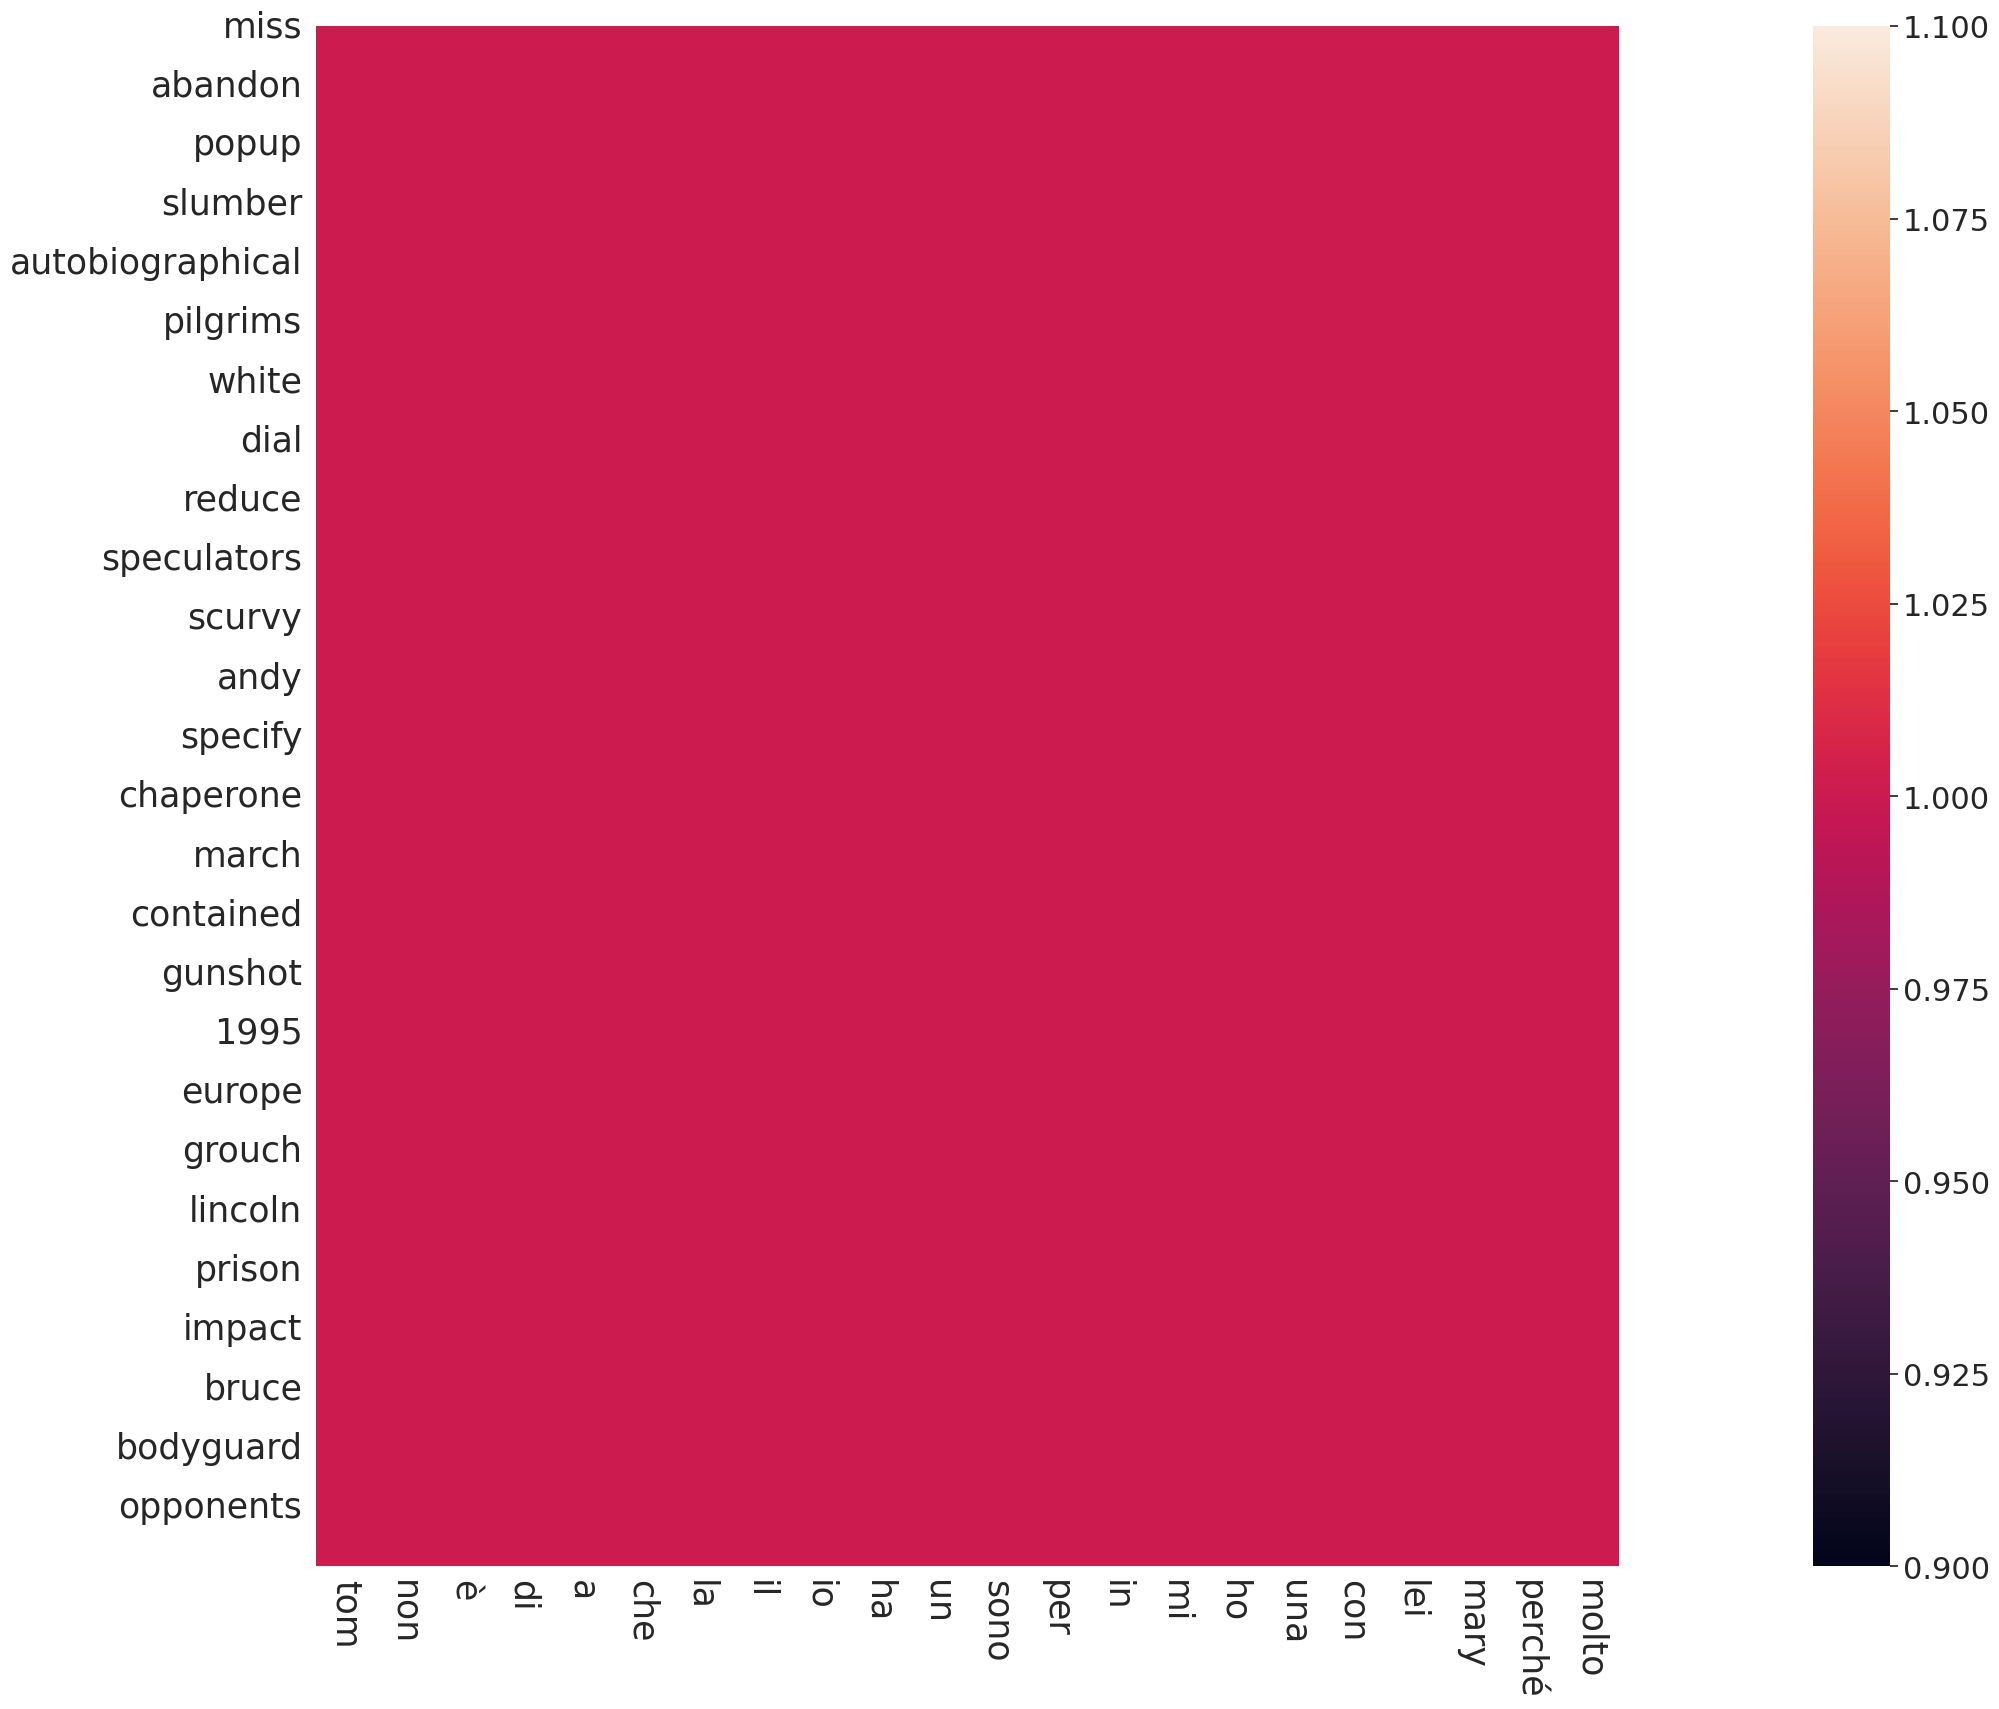

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''

  words=[]
  all_attention_weights=[]
  input_sentence=[input_sentence]
  batch_size=1
  tokenized_sent=tknizer_ita.texts_to_sequences(input_sentence)
  #print(tokenized_sent)
  padded_sent=padded_italian_train=tf.keras.utils.pad_sequences(tokenized_sent, maxlen=italian_pad_length,padding='post' )
  encoder_h, encoder_c=model_2.layers[0].initialize_states(batch_size)
  encoder_output,encoder_h, encoder_c= model_2.layers[0](padded_sent, states=[encoder_h, encoder_c])

  start_index=tknizer_eng.word_index.get('<start>')
  end_index=tknizer_eng.word_index.get('<end>')
  for i in range(english_pad_length):
    decoder_output, decoder_h, decoder_c, attention_weights, context_vector = model_2.layers[1].osd(tf.convert_to_tensor([[start_index]]), encoder_output, encoder_h, encoder_c)
    all_attention_weights.append(attention_weights)
    
    predicted_out=tf.keras.layers.Flatten()(decoder_output)
    output=Dense(vocab_size_eng, 'softmax')(predicted_out)
    
    output_index=np.argmax(output)
    start_index=output_index
    #print(output_index)
    words.append(list(tknizer_eng.word_index.keys())[output_index])

    #print(list(tknizer_eng.word_index.keys())[output_index])

    if output_index==end_index:
      break;

  #index number of all the non zero letters
  input_words=padded_sent
  no_pad_words_input=np.argwhere(padded_sent[0]!=0).reshape(1,-1)[0]

  all_attention_weights=tf.convert_to_tensor(all_attention_weights)
  all_attention_weights=tf.squeeze(all_attention_weights, axis=(1,3))
  all_attention_weights=np.array(all_attention_weights)

  non_zero_weights=all_attention_weights[:,no_pad_words_input]

  ita_words=[list(tknizer_ita.word_index.keys())[j] for j in no_pad_words_input]

  plot_attention(non_zero_weights,ita_words, words )
  return ' '.join(words)

i='so che aggiungere frasi soltanto nella sua lingua madre o nella sua lingua più forte non è probabilmente divertente quanto esercitarsi a scrivere in lingue straniere ma per piacere non aggiunga frasi nel corpus di tatoeba se non è assolutamente sicuro che siano corrette se vuole praticare le lingue che sta studiando per piacere lo faccia utilizzando un sito web progettato a tale scopo come wwwlang 8com'
a=predict(i)

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'it is ship'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

BLEU score: 0


In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''

  words=[]
  all_attention_weights=[]
  input_sentence=[input_sentence]
  batch_size=1
  tokenized_sent=tknizer_ita.texts_to_sequences(input_sentence)
  #print(tokenized_sent)
  padded_sent=padded_italian_train=tf.keras.utils.pad_sequences(tokenized_sent, maxlen=italian_pad_length,padding='post' )
  encoder_h, encoder_c=model_2.layers[0].initialize_states(batch_size)
  encoder_output,encoder_h, encoder_c= model_2.layers[0](padded_sent, states=[encoder_h, encoder_c])

  start_index=tknizer_eng.word_index.get('<start>')
  end_index=tknizer_eng.word_index.get('<end>')
  for i in range(english_pad_length):
    decoder_output, decoder_h, decoder_c, attention_weights, context_vector = model_2.layers[1].osd(tf.convert_to_tensor([[start_index]]), encoder_output, encoder_h, encoder_c)
    all_attention_weights.append(attention_weights)

    predicted_out=tf.keras.layers.Flatten()(decoder_output)
    output=Dense(vocab_size_eng, 'softmax')(predicted_out)

    output_index=np.argmax(output)
    start_index=output_index
    #print(output_index)
    words.append(list(tknizer_eng.word_index.keys())[output_index])

    #print(list(tknizer_eng.word_index.keys())[output_index])

    if output_index==end_index:
      break;

  #index number of all the non zero letters
  input_words=padded_sent
  no_pad_words_input=np.argwhere(padded_sent[0]!=0).reshape(1,-1)[0]

  all_attention_weights=tf.convert_to_tensor(all_attention_weights)
  all_attention_weights=tf.squeeze(all_attention_weights, axis=(1,3))
  all_attention_weights=np.array(all_attention_weights)

  non_zero_weights=all_attention_weights[:,no_pad_words_input]

  ita_words=[list(tknizer_ita.word_index.keys())[j] for j in no_pad_words_input]

  #plot_attention(non_zero_weights,ita_words, words )
  return ' '.join(words)


In [ ]:
samples=test['italian'].sample(1000)
predicted_eng_samples_model_2=samples.apply(predict)


In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm

blue_scores=[]

for i in tqdm(range(len(samples))):
  reference=samples.values[i]
  translation=predicted_eng_samples_model_2.values[i]
  b=bleu.sentence_bleu([reference], translation)
  blue_scores.append(b)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 908.97it/s]


In [ ]:
print('The Blue Score for the 1000 Samples is',np.mean(np.array(blue_scores)))

The Blue Score for the 1000 Samples is 0.010900558597717776


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [29]:
tf.keras.backend.clear_session()
size=1024

model_3=encoder_decoder(inp_vocab_size=vocab_size_ita, out_vocab_size=vocab_size_eng+1,embedding_size=100, lstm_size=100, input_length_l1=italian_pad_length, input_length_l2=english_pad_length, dec_units=100, score_fun='general', att_units=100, batch_size=size )

model_3.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=loss_function)

tensorboard=tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/seq models/logs/logs_model_2')
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/seq models/models/model_2.hd5', monitor='val_loss')
lr_rate=tf.keras.callbacks.ReduceLROnPlateau(patience=4,min_delta=0.01)
stopping=tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=3)

callbacks=[tensorboard,checkpoint,lr_rate,stopping]

model_3.fit(train_data_loader, epochs=10, batch_size=size, validation_data=validation_data_loader)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


223/223 [==============================] - 243s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 2/10
223/223 [==============================] - 237s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 3/10
223/223 [==============================] - 243s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 4/10
223/223 [==============================] - 245s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 5/10
223/223 [==============================] - 245s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 6/10
223/223 [==============================] - 242s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 7/10
223/223 [==============================] - 241s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 8/10
223/223 [==============================] - 240s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 9/10
223/223 [==============================] - 240s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 10/10
223/223 [==============================] - 244s 1s/step - loss: 2.4996 - val_loss: 2.4922


In [31]:
def predict_3(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''

  words=[]
  all_attention_weights=[]
  input_sentence=[input_sentence]
  batch_size=1
  tokenized_sent=tknizer_ita.texts_to_sequences(input_sentence)
  #print(tokenized_sent)
  padded_sent=padded_italian_train=tf.keras.utils.pad_sequences(tokenized_sent, maxlen=italian_pad_length,padding='post' )
  encoder_h, encoder_c=model_3.layers[0].initialize_states(batch_size)
  encoder_output,encoder_h, encoder_c= model_3.layers[0](padded_sent, states=[encoder_h, encoder_c])

  start_index=tknizer_eng.word_index.get('<start>')
  end_index=tknizer_eng.word_index.get('<end>')
  for i in range(english_pad_length):
    decoder_output, decoder_h, decoder_c, attention_weights, context_vector = model_3.layers[1].osd(tf.convert_to_tensor([[start_index]]), encoder_output, encoder_h, encoder_c)
    all_attention_weights.append(attention_weights)

    predicted_out=tf.keras.layers.Flatten()(decoder_output)
    output=Dense(vocab_size_eng, 'softmax')(predicted_out)

    output_index=np.argmax(output)
    start_index=output_index
    #print(output_index)
    words.append(list(tknizer_eng.word_index.keys())[output_index])

    #print(list(tknizer_eng.word_index.keys())[output_index])

    if output_index==end_index:
      break;

  #index number of all the non zero letters
  input_words=padded_sent
  no_pad_words_input=np.argwhere(padded_sent[0]!=0).reshape(1,-1)[0]

  all_attention_weights=tf.convert_to_tensor(all_attention_weights)
  all_attention_weights=tf.squeeze(all_attention_weights, axis=(1,3))
  all_attention_weights=np.array(all_attention_weights)

  non_zero_weights=all_attention_weights[:,no_pad_words_input]

  ita_words=[list(tknizer_ita.word_index.keys())[j] for j in no_pad_words_input]

  #plot_attention(non_zero_weights,ita_words, words )
  return ' '.join(words)


In [32]:
samples=test['italian'].sample(1000)
predicted_eng_samples_model_3=samples.apply(predict_3)

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

blue_scores=[]

for i in tqdm(range(len(samples))):
  reference=samples.values[i]
  translation=predicted_eng_samples_model_3.values[i]
  b=bleu.sentence_bleu([reference], translation)
  blue_scores.append(b)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 1000/1000 [00:00<00:00, 1587.28it/s]


In [33]:
print('The Blue Score for the 1000 Samples is',np.mean(np.array(blue_scores)))

The Blue Score for the 1000 Samples is 0.010501668310781611


In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [34]:
train_dataset=Dataset(train, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)
validation_dataset=Dataset(validation, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)
test_dataset=Dataset(test, tknizer_ita, tknizer_eng, max_len_ita=22, max_len_eng=26)

size=1024

train_data_loader=Dataloder(train_dataset, batch_size=size)
validation_data_loader=Dataloder(validation_dataset, batch_size=size)
test_data_loader=Dataloder(test_dataset, batch_size=size)

In [35]:
tf.keras.backend.clear_session()
size=1024

model_4=encoder_decoder(inp_vocab_size=vocab_size_ita, out_vocab_size=vocab_size_eng+1,embedding_size=100, lstm_size=20, input_length_l1=italian_pad_length, input_length_l2=english_pad_length, dec_units=20, score_fun='concat', att_units=20, batch_size=size )

model_4.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=loss_function)

tensorboard=tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/seq models/logs/logs_model_2')
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/seq models/models/model_2.hd5', monitor='val_loss')
lr_rate=tf.keras.callbacks.ReduceLROnPlateau(patience=4,min_delta=0.01)
stopping=tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=3)

callbacks=[tensorboard,checkpoint,lr_rate,stopping]

model_4.fit(train_data_loader, epochs=10, batch_size=size, validation_data=validation_data_loader)

Epoch 1/10
223/223 [==============================] - 284s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 2/10
223/223 [==============================] - 279s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 3/10
223/223 [==============================] - 279s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 4/10
223/223 [==============================] - 271s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 5/10
223/223 [==============================] - 310s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 6/10
223/223 [==============================] - 269s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 7/10
223/223 [==============================] - 283s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 8/10
223/223 [==============================] - 279s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 9/10
223/223 [==============================] - 278s 1s/step - loss: 2.4996 - val_loss: 2.4922
Epoch 10/10
223/223 [==============================] - 277s 1s/step - loss: 2.4996 - val_lo

In [37]:
def predict_3(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''

  words=[]
  all_attention_weights=[]
  input_sentence=[input_sentence]
  batch_size=1
  tokenized_sent=tknizer_ita.texts_to_sequences(input_sentence)
  #print(tokenized_sent)
  padded_sent=padded_italian_train=tf.keras.utils.pad_sequences(tokenized_sent, maxlen=italian_pad_length,padding='post' )
  encoder_h, encoder_c=model_4.layers[0].initialize_states(batch_size)
  encoder_output,encoder_h, encoder_c= model_4.layers[0](padded_sent, states=[encoder_h, encoder_c])

  start_index=tknizer_eng.word_index.get('<start>')
  end_index=tknizer_eng.word_index.get('<end>')
  for i in range(english_pad_length):
    decoder_output, decoder_h, decoder_c, attention_weights, context_vector = model_4.layers[1].osd(tf.convert_to_tensor([[start_index]]), encoder_output, encoder_h, encoder_c)
    all_attention_weights.append(attention_weights)

    predicted_out=tf.keras.layers.Flatten()(decoder_output)
    output=Dense(vocab_size_eng, 'softmax')(predicted_out)

    output_index=np.argmax(output)
    start_index=output_index
    #print(output_index)
    words.append(list(tknizer_eng.word_index.keys())[output_index])

    #print(list(tknizer_eng.word_index.keys())[output_index])

    if output_index==end_index:
      break;

  #index number of all the non zero letters
  input_words=padded_sent
  no_pad_words_input=np.argwhere(padded_sent[0]!=0).reshape(1,-1)[0]

  all_attention_weights=tf.convert_to_tensor(all_attention_weights)
  all_attention_weights=tf.squeeze(all_attention_weights, axis=(1,3))
  all_attention_weights=np.array(all_attention_weights)

  non_zero_weights=all_attention_weights[:,no_pad_words_input]

  ita_words=[list(tknizer_ita.word_index.keys())[j] for j in no_pad_words_input]

  #plot_attention(non_zero_weights,ita_words, words )
  return ' '.join(words)


In [40]:
samples=test['italian'].sample(1000)
predicted_eng_samples_model_4=samples.apply(predict_3)

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

blue_scores=[]

for i in tqdm(range(len(samples))):
  reference=samples.values[i]
  translation=predicted_eng_samples_model_4.values[i]
  b=bleu.sentence_bleu(reference, translation)
  blue_scores.append(b)

100%|██████████| 1000/1000 [00:07<00:00, 136.16it/s]


In [39]:
print('The Blue Score for the 1000 Samples is',np.mean(np.array(blue_scores)))

The Blue Score for the 1000 Samples is 9.002449492268615e-232


In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Write your observations on each of the scoring function